Sat Jun 21st 2025,
Jakob Balkovec

In [1]:
import os
from collections import defaultdict, Counter

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN

# paths
xml_dir = r"../data/raw/groundtruth"
xml_files = [f for f in os.listdir(xml_dir) if f.endswith('.xml')]

# data containers
lesion_stats = defaultdict(list)


## Basic Analysis of a Dataset

In [2]:
for xml_file in xml_files:
    tree = ET.parse(os.path.join(xml_dir, xml_file))
    root = tree.getroot()

    for mark in root.findall(".//marking"):
        lesion_type = mark.find("markingtype").text
        confidence = mark.find("confidencelevel").text
        coords_text = mark.find(".//centroid/coords2d").text
        radius_elem = mark.find(".//circleregion/radius")

        x,y = map(float, coords_text.split(","))
        radius = float(radius_elem.text) if radius_elem is not None else -1.0 # default to -1 if not found

        lesion_stats['type'].append(lesion_type)
        lesion_stats['confidence'].append(confidence)
        lesion_stats['x'].append(x)
        lesion_stats['y'].append(y)
        lesion_stats['radius'].append(radius)

type_counts = Counter(lesion_stats['type'])
confidence_counts = Counter(lesion_stats['confidence'])

print("Lesion Types Count:\n", type_counts)
print("\nConfidence Levels:\n", confidence_counts)


Lesion Types Count:
 Counter({'Haemorrhages': 4546, 'Red_small_dots': 4364, 'Hard_exudates': 1584, 'Soft_exudates': 594, 'Disc': 534, 'IRMA': 140, 'Neovascularisation': 96, 'Fundus_area': 10})

Confidence Levels:
 Counter({'High': 8988, 'Medium': 2470, 'Low': 410})


## Lesion Type Distribution

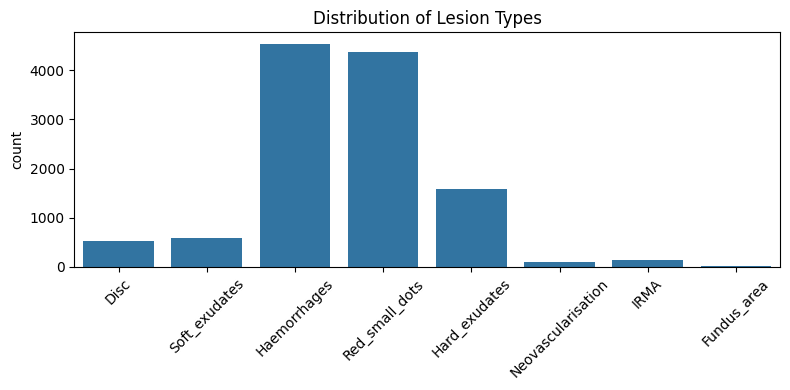

In [3]:
plt.figure(figsize=(8, 4))
sns.countplot(x=lesion_stats['type'], order=type_counts.keys())
plt.title("Distribution of Lesion Types")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Lesion Radius Distribution

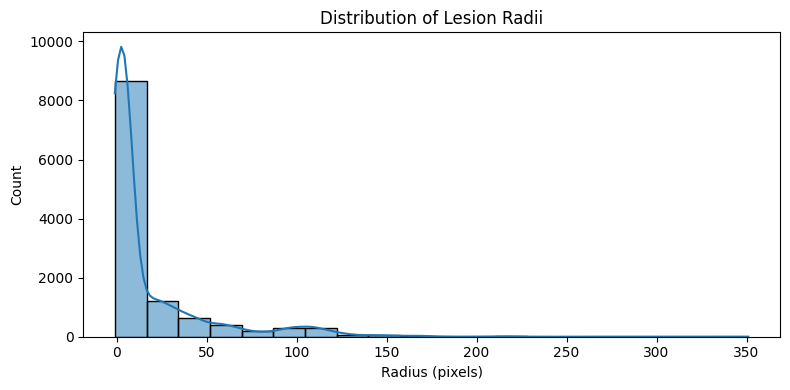

In [4]:
plt.figure(figsize=(8, 4))
sns.histplot(lesion_stats['radius'], bins=20, kde=True)
plt.title("Distribution of Lesion Radii")
plt.xlabel("Radius (pixels)")
plt.tight_layout()
plt.show()


## Spacial Scatter of Lesion Centers

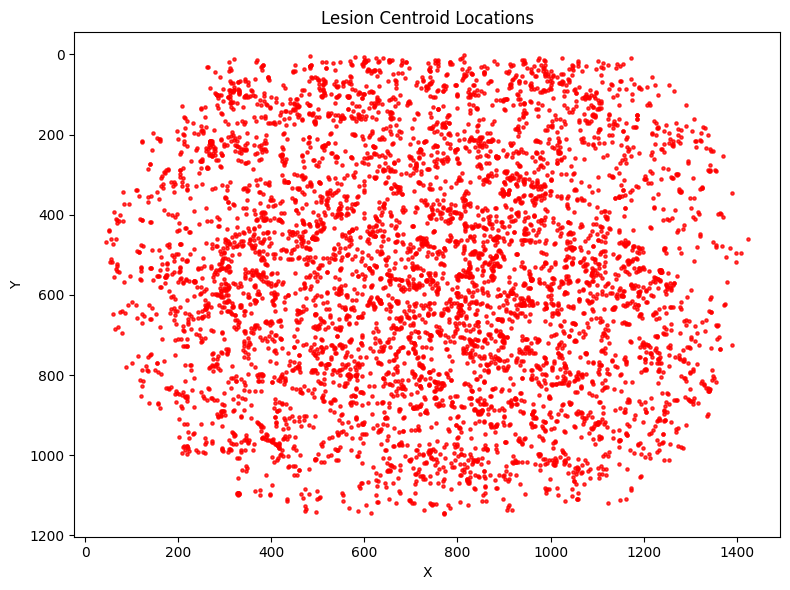

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(lesion_stats['x'], lesion_stats['y'], alpha=0.5, c='red', s=5)
plt.title("Lesion Centroid Locations")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Pandas Data Frame

In [6]:
df = pd.DataFrame(lesion_stats)
df['image'] = [f.split("_")[0] for f in xml_files for _ in ET.parse(os.path.join(xml_dir, f)).findall(".//marking")]


## Per-image Lesion Distribution

type       Disc  Fundus_area  Haemorrhages  Hard_exudates  IRMA  \
image                                                             
diaretdb1   534           10          4546           1584   140   

type       Neovascularisation  Red_small_dots  Soft_exudates  
image                                                         
diaretdb1                  96            4364            594  


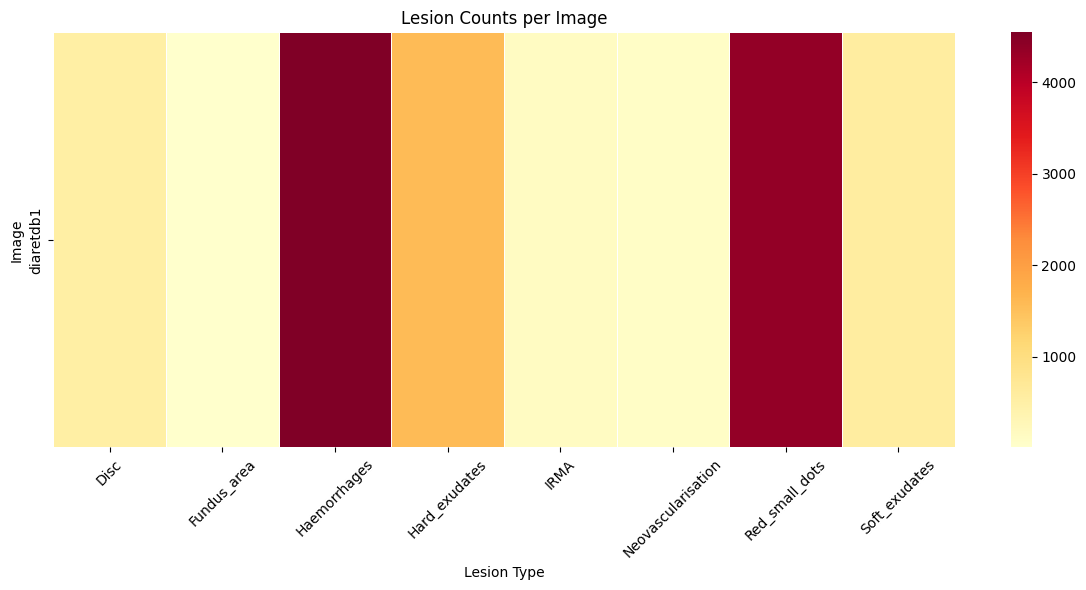

In [7]:
per_image_counts = df.groupby(['image', 'type']).size().unstack(fill_value=0)
print(per_image_counts.head())

plt.figure(figsize=(12, 6))
sns.heatmap(per_image_counts, cmap="YlOrRd", linewidths=0.5)
plt.title("Lesion Counts per Image")
plt.xticks(rotation=45)
plt.xlabel("Lesion Type")
plt.ylabel("Image")
plt.tight_layout()
plt.show()


## Lesion Radius by Type

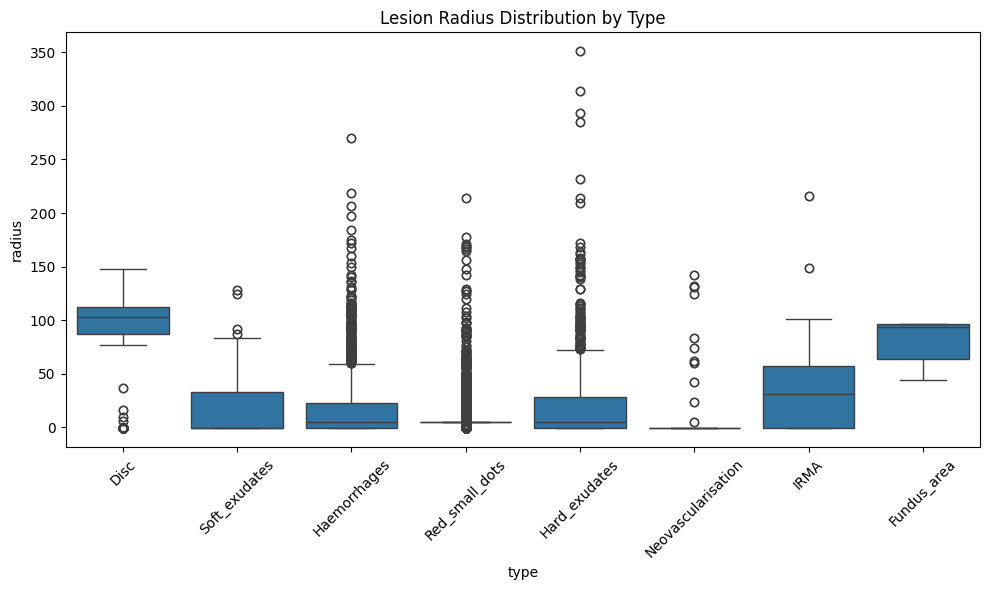

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="type", y="radius")
plt.title("Lesion Radius Distribution by Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Confidence Level by Lesion Type

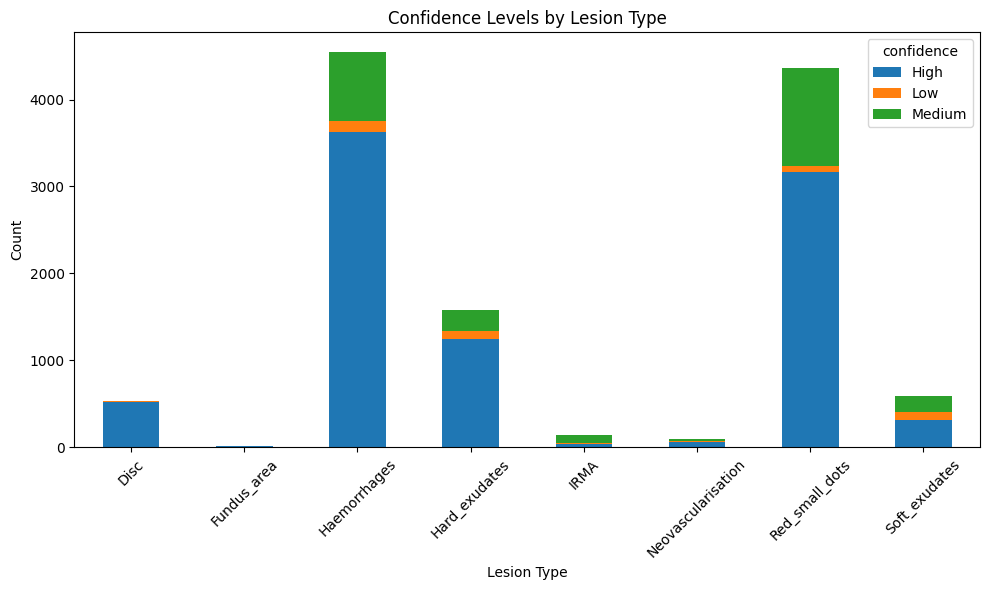

In [9]:
conf_type_counts = df.groupby(['type', 'confidence']).size().unstack(fill_value=0)
conf_type_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title("Confidence Levels by Lesion Type")
plt.xlabel("Lesion Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Spatial Clustering (DBSCAN)

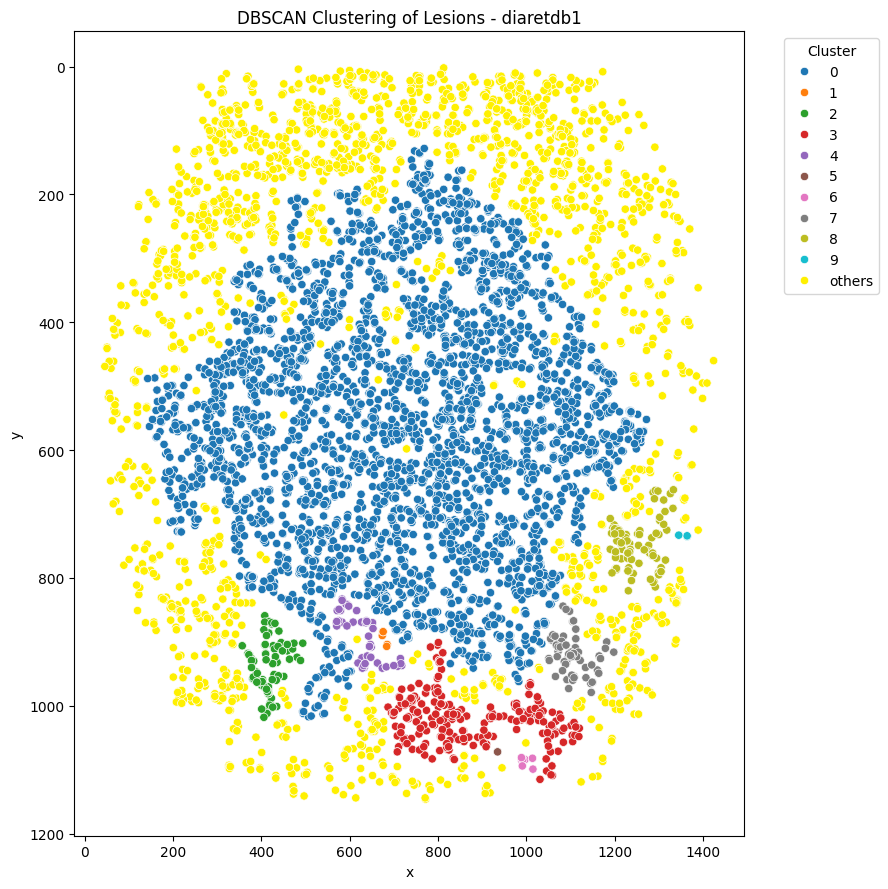

In [10]:
example_img = df[df['image'] == df['image'].iloc[0]]
coords = example_img[['x', 'y']].values
db = DBSCAN(eps=20, min_samples=2).fit(coords)
example_img['cluster'] = db.labels_

max_clusters = 10
example_img['cluster_limited'] = example_img['cluster'].apply(lambda x: x if x < max_clusters else 'others')

# palette: first 10 from tab10 + custom yellow for 'others'
base_palette = sns.color_palette("tab10", max_clusters)
custom_palette = {i: base_palette[i] for i in range(max_clusters)}
custom_palette['others'] = '#FFF000'  # bright yellow to make it stand out

plt.figure(figsize=(9, 9))
sns.scatterplot(data=example_img, x="x", y="y", hue="cluster_limited", palette=custom_palette)
plt.title(f"DBSCAN Clustering of Lesions - {example_img['image'].iloc[0]}")
plt.gca().invert_yaxis()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## KDE Heatmaps per Lesion Type

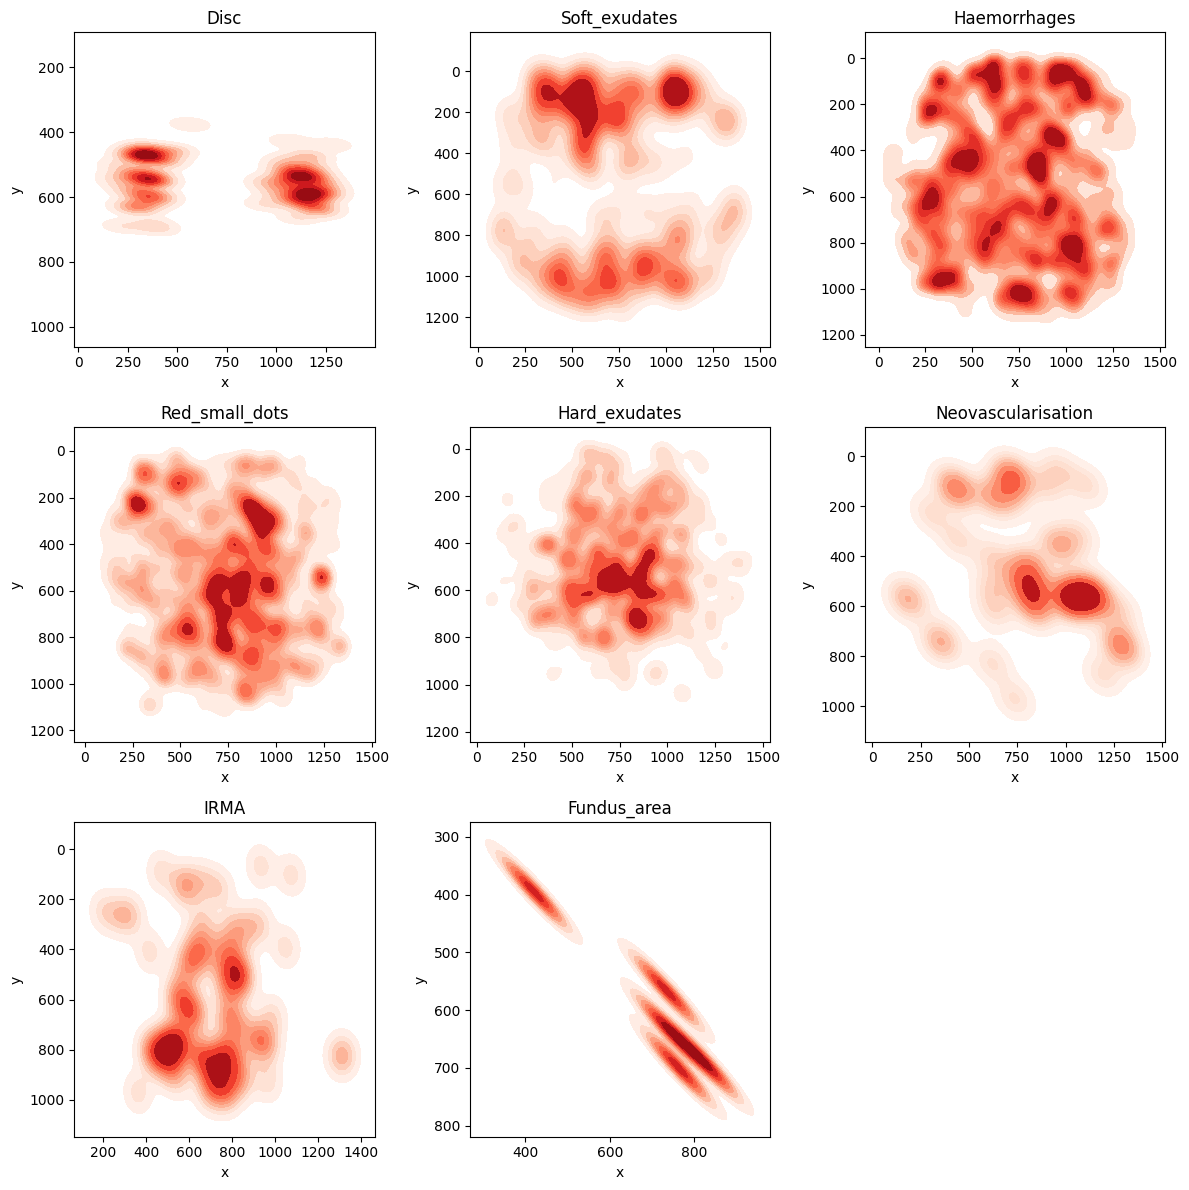

In [11]:
lesion_types = df['type'].unique()
n_types = len(lesion_types)
n_cols = 3
n_rows = int(np.ceil(n_types / n_cols))

plt.figure(figsize=(n_cols * 4, n_rows * 4))
for i, lesion_type in enumerate(lesion_types, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(
        x=df[df['type'] == lesion_type]['x'],
        y=df[df['type'] == lesion_type]['y'],
        fill=True, cmap='Reds', bw_adjust=0.5
    )
    plt.title(lesion_type)
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
